In [1]:
import numpy as np
import pandas as pd
from scipy.stats import kstest,ttest_ind
import itertools as it
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})

In [2]:
variants_file = "/data5/UK_Biobank/annotations/vep/2022_03_13/data/variants_by_gene/lof_missense_pred_freq_0.01.tsv"
phenotypes_file = "/data5/deepro/ukbiobank/papers/bmi_project/2_prepare_data_for_analysis/white_british/data/samples_with_residuals.csv"

In [3]:
combinations_files = [
    "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/white_british/data/parsed_tables/combo_2.csv",
    "/data5/deepro/ukbiobank/papers/bmi_project/3_run_rarecomb/white_british/data/parsed_tables/combo_3.csv"
    ]


In [4]:
def get_merged_combo_file(combo_files):
    combo_dfs = [pd.read_csv(cf) for cf in combo_files]
    combo_df = pd.concat(combo_dfs)
    return combo_df

def get_case_samples_with_combos(combo_df):
    return set(sum(list(map(lambda v: v.split(","), combo_df.Case_Samples.values)), []))

In [5]:
combo_df = get_merged_combo_file(combinations_files)
case_samples = get_case_samples_with_combos(combo_df)

In [6]:
variants_df = pd.read_csv(variants_file, sep="\t", low_memory=False, usecols=["Sample", "variant_id", "Gene", "SYMBOL", "Mut_type"], dtype=str)
phenotypes_df = pd.read_csv(phenotypes_file, low_memory=False, usecols=["eid", "bmi"], dtype={"eid": str, "bmi": np.float64})

In [7]:
variants_df = variants_df.loc[variants_df.Sample.isin(case_samples)]

In [9]:
variant_type_dict = {"eid":[], "vtype":[]}

for uci,csamples in zip(combo_df.unique_combo_id, combo_df.Case_Samples):
    genes = uci.split("_")
    csamples = csamples.split(",")
    svdf = variants_df.loc[(variants_df.Gene.isin(genes))&(variants_df.Sample.isin(csamples))]
    for group in svdf.groupby("Sample"):
        variant_type_dict["eid"].append(group[0])
        variant_type_dict["vtype"].append("-".join(sorted(group[1].Mut_type.unique())))

In [10]:
vtype_bmi_df = pd.DataFrame(variant_type_dict).merge(phenotypes_df, left_on="eid", right_on="eid")

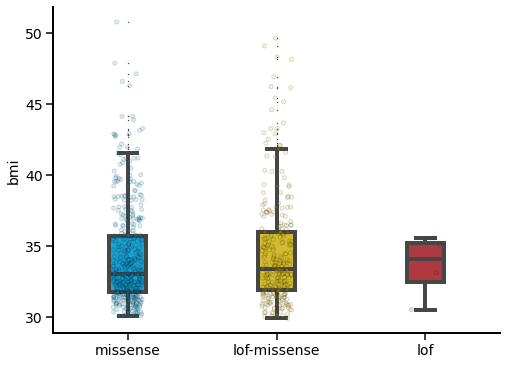

In [11]:
boxdf = vtype_bmi_df

# Define Canvas
fig,ax = plt.subplots(1, 1, figsize=(8, 6))

# Box Plot
sns_strip = sns.stripplot(
    data=boxdf,
    palette=["#00ADEE", "#eecc16", "#c1272d", ],  # '#D1245D', '#00ADEE', '#D1245D', '#00ADEE' "#0000a7"
    x="vtype",
    y="bmi",
    order=["missense", "lof-missense", "lof"],
    orient="v",
    s=4,
    alpha=0.15, ec='black', linewidth=1, jitter=True, facecolors="none", dodge=False, ax=ax 
    )

sns_box = sns.boxplot(
    data=boxdf,
    palette=["#00ADEE", "#eecc16", "#c1272d", ],  # '#D1245D', '#00ADEE', '#D1245D', '#00ADEE' "#0000a7"
    x="vtype",
    y="bmi",
    order=["missense", "lof-missense", "lof"],
    hue_order=["missense", "lof-missense", "lof"],
    dodge=False, width=0.25, linewidth=4, fliersize=0.5)


# Adjust Axis
# ax.set_yticks([-0.02, 0, 0.02, 0.04])
# ax.set_ylim((-0.025, 0.05))
# ax.set_ylabel('Percentage')
# ax.set_xticklabels(["Akbari\ngenes", "Turcot\ngenes", "Digenic\ncombinations", "Trigenic\ncombinations", ], rotation=0)
ax.set_xlabel("")

# Remove Spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

In [12]:
for test_vars in list(it.combinations(vtype_bmi_df.vtype.unique(), 2)):
    bmi_g1 = vtype_bmi_df.loc[vtype_bmi_df.vtype==test_vars[0], "bmi"]
    bmi_g2 = vtype_bmi_df.loc[vtype_bmi_df.vtype==test_vars[1], "bmi"]
    print(f"Testing {test_vars[0]} vs {test_vars[1]}")
    print(ttest_ind(bmi_g1, bmi_g2))

Testing missense vs lof-missense
Ttest_indResult(statistic=-1.2130443455154405, pvalue=0.22551629181278107)
Testing missense vs lof
Ttest_indResult(statistic=0.3650832832549634, pvalue=0.71522708312061)
Testing lof-missense vs lof
Ttest_indResult(statistic=0.505356850611089, pvalue=0.613702958442156)
